# Basic Walk-Through: K-Nearest Neighbors

### Loading Libraries

In [31]:
# Numerical Computing
import numpy as np

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# YellowBrick
from yellowbrick.model_selection import ValidationCurve, LearningCurve

# Data Manipulation
import pandas as pd

# Warnings
import warnings

# Path
from pathlib import Path

# SciPy
from scipy.stats import spearmanr

# Scikit-Learn
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer
from sklearn.preprocessing import StandardScaler, scale
from sklearn.feature_selection import mutual_info_regression

from sklearn.metrics import (mean_squared_error,
                             mean_absolute_error,
                             mean_squared_log_error, 
                             median_absolute_error, 
                             explained_variance_score, 
                             r2_score)

from sklearn.neighbors import (KNeighborsClassifier, 
                               KNeighborsRegressor)

from sklearn.model_selection import (cross_val_score, 
                                     cross_val_predict, 
                                     GridSearchCV)

In [18]:
sns.set_style('whitegrid')

warnings.filterwarnings('ignore')

In [19]:
%matplotlib inline

### Retreiving Data

In [9]:
DATA_PATH = Path('/Users/joaquinromero/desktop/MLAT/data')

In [10]:
house_sales = pd.read_csv('/Users/joaquinromero/Desktop/MLAT/data/kc_house_data.csv')

house_sales = house_sales.drop(
    ['id', 'zipcode', 'lat', 'long', 'date'], axis=1)
house_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21613 non-null  float64
 1   bedrooms       21613 non-null  int64  
 2   bathrooms      21613 non-null  float64
 3   sqft_living    21613 non-null  int64  
 4   sqft_lot       21613 non-null  int64  
 5   floors         21613 non-null  float64
 6   waterfront     21613 non-null  int64  
 7   view           21613 non-null  int64  
 8   condition      21613 non-null  int64  
 9   grade          21613 non-null  int64  
 10  sqft_above     21613 non-null  int64  
 11  sqft_basement  21613 non-null  int64  
 12  yr_built       21613 non-null  int64  
 13  yr_renovated   21613 non-null  int64  
 14  sqft_living15  21613 non-null  int64  
 15  sqft_lot15     21613 non-null  int64  
dtypes: float64(3), int64(13)
memory usage: 2.6 MB


### Select & Transform Features

#### Asset Prices often have Long Tails

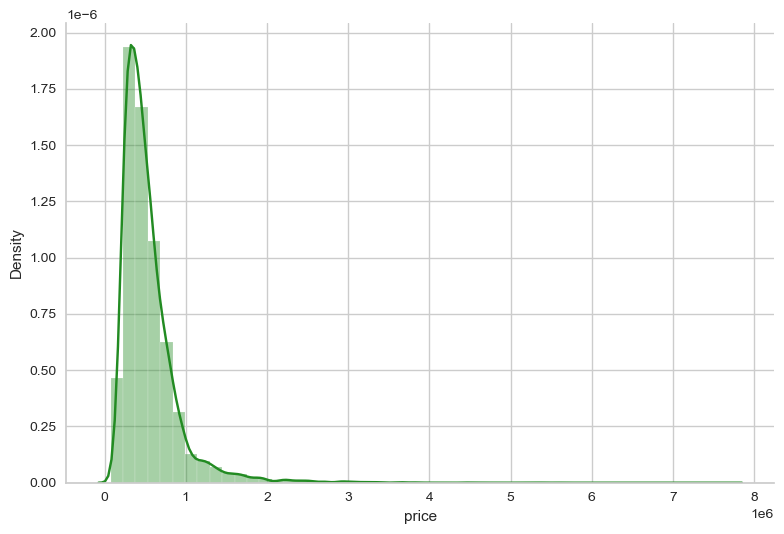

In [25]:
sns.distplot(house_sales.price, color='forestgreen')
sns.despine()
plt.tight_layout();
plt.show()

#### Using Log-Transform

In [12]:
# Features
X_all = house_sales.drop('price', axis=1)

# Target
y = np.log(house_sales.price)

#### Mutual Information Regression

In [13]:
mi_reg = pd.Series(mutual_info_regression(X_all, y),
                   index=X_all.columns).sort_values(ascending=False)
mi_reg

grade            0.351714
sqft_living      0.349707
sqft_living15    0.271880
sqft_above       0.257579
bathrooms        0.205303
sqft_lot15       0.085402
bedrooms         0.079783
yr_built         0.077367
floors           0.071214
sqft_basement    0.065187
sqft_lot         0.062366
view             0.058269
condition        0.012089
yr_renovated     0.010595
waterfront       0.006872
dtype: float64

In [14]:
X = X_all.loc[:, mi_reg.iloc[:10].index]

#### Bivariate Scatter Plots

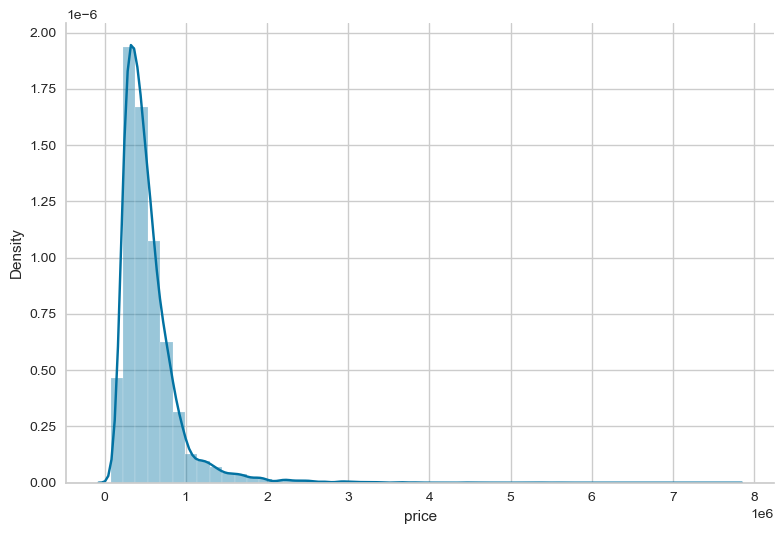

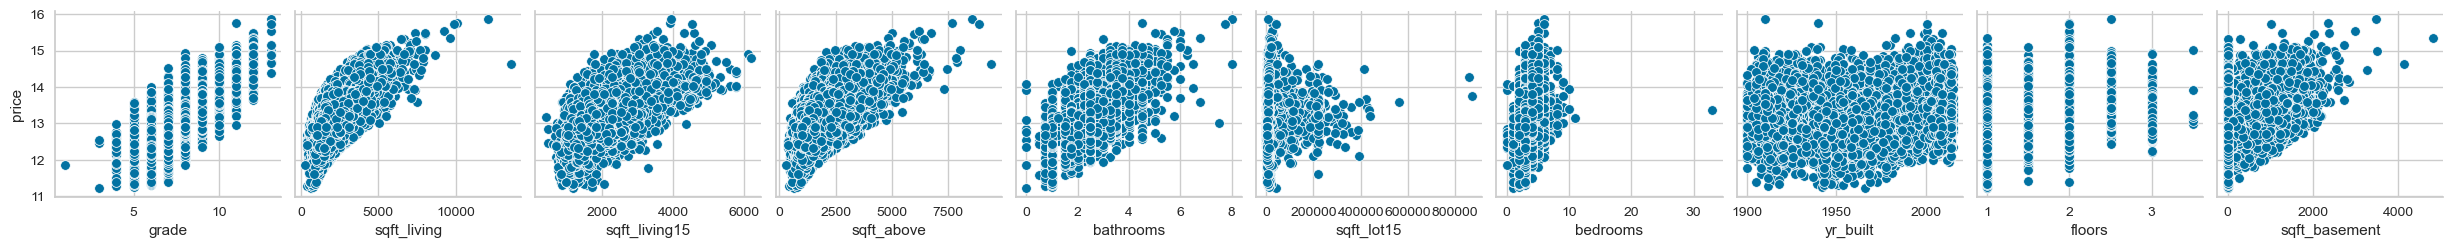

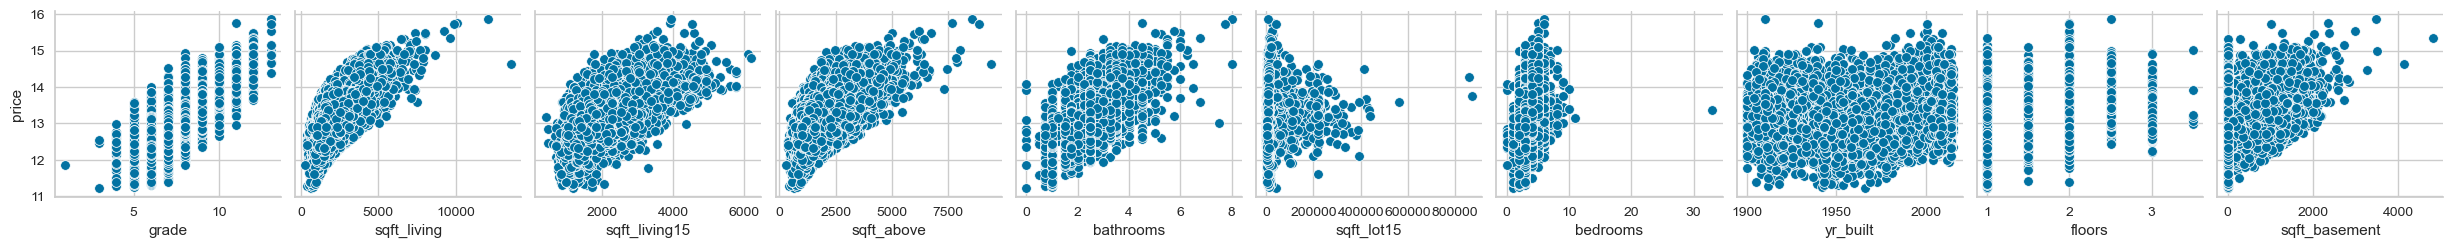

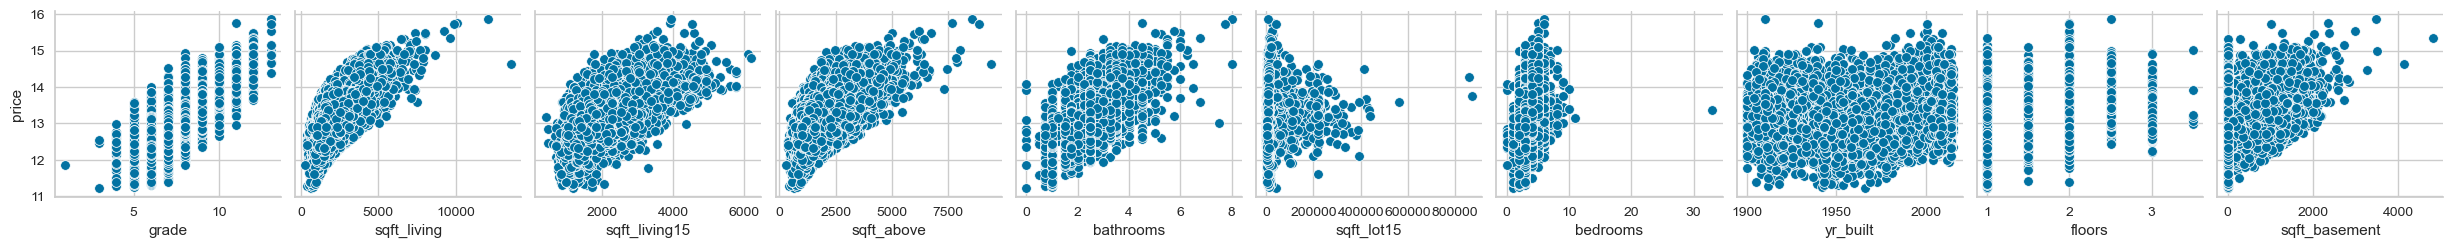

In [17]:
g = sns.pairplot(X.assign(price=y), y_vars=['price'], x_vars=X.columns)
sns.despine();
plt.show()

#### Exploring Correlations

In [20]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   grade          21613 non-null  int64  
 1   sqft_living    21613 non-null  int64  
 2   sqft_living15  21613 non-null  int64  
 3   sqft_above     21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_lot15     21613 non-null  int64  
 6   bedrooms       21613 non-null  int64  
 7   yr_built       21613 non-null  int64  
 8   floors         21613 non-null  float64
 9   sqft_basement  21613 non-null  int64  
dtypes: float64(2), int64(8)
memory usage: 1.6 MB


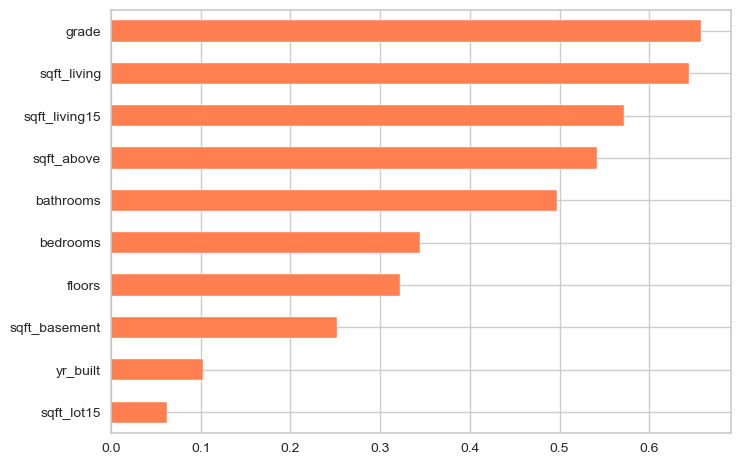

In [23]:
correl = X.apply(lambda x: spearmanr(x, y)[0])

correl.sort_values().plot.barh(color='coral');

plt.show()

### KNN Regression

#### In-sample Performance with Default Settings

In [26]:
X_scaled = scale(X)

In [28]:
# Placing Model
model = KNeighborsRegressor()

# Fitting Model
model.fit(X=X_scaled, y=y)

KNeighborsRegressor()

In [29]:
y_pred = model.predict(X_scaled)

### Regression Error Metrics

In [32]:
from sklearn.metrics import (mean_squared_error,
                             mean_absolute_error,
                             mean_squared_log_error, 
                             median_absolute_error, 
                             explained_variance_score, 
                             r2_score)

#### Computing `The Prediction Error`

In [33]:
error = (y - y_pred).rename('Prediction Errors')

In [34]:
scores = dict(
    rmse=np.sqrt(mean_squared_error(y_true=y, y_pred=y_pred)),
    rmsle=np.sqrt(mean_squared_log_error(y_true=y, y_pred=y_pred)),
    mean_ae=mean_absolute_error(y_true=y, y_pred=y_pred),
    median_ae=median_absolute_error(y_true=y, y_pred=y_pred),
    r2score=explained_variance_score(y_true=y, y_pred=y_pred)
)

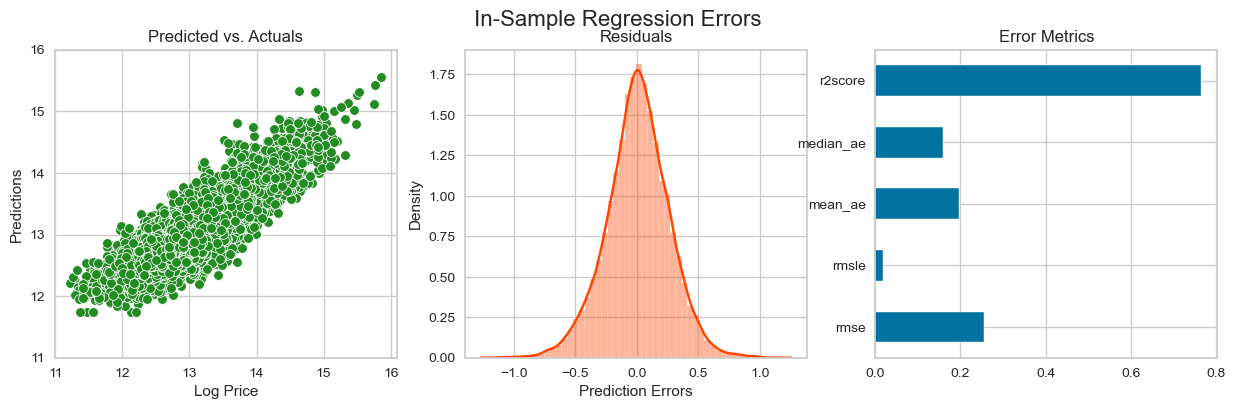

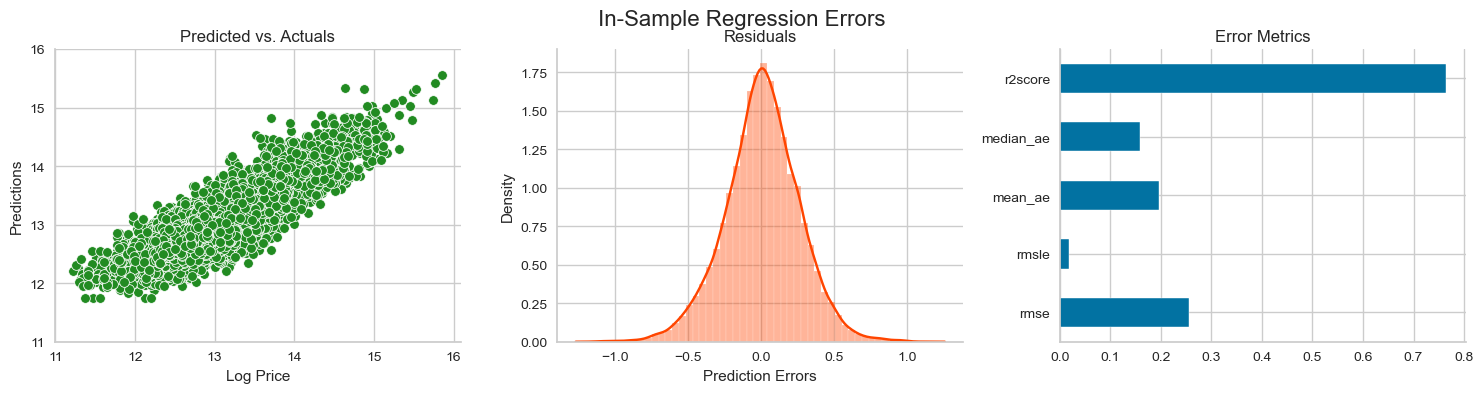

In [42]:
fig, axes = plt.subplots(ncols=3, figsize=(15, 4))

sns.scatterplot(x=y, y=y_pred, ax=axes[0], color='forestgreen')
axes[0].set_xlabel('Log Price')
axes[0].set_ylabel('Predictions')
axes[0].set_ylim(11, 16)
axes[0].set_title('Predicted vs. Actuals')
sns.distplot(error, ax=axes[1], color='orangered')
axes[1].set_title('Residuals')
pd.Series(scores).plot.barh(ax=axes[2], title='Error Metrics')
fig.suptitle('In-Sample Regression Errors', fontsize=16)
sns.despine()
fig.tight_layout()
fig.subplots_adjust(top=.88)
plt.show()

#### Cross-Validation

In [43]:
def rmse(y_true, pred):
    return np.sqrt(mean_squared_error(y_true=y_true, y_pred=pred))

rmse_score = make_scorer(rmse)

In [44]:
cv_rmse = {}
n_neighbors = [1] + list(range(5, 51, 5))
for n in n_neighbors:
    pipe = Pipeline([('scaler', StandardScaler()),
                     ('knn', KNeighborsRegressor(n_neighbors=n))])                    
    cv_rmse[n] = cross_val_score(pipe, 
                                X=X, 
                                y=y,
                                scoring=rmse_score,
                                cv=5)

In [45]:
cv_rmse = pd.DataFrame.from_dict(cv_rmse, orient='index')
best_n, best_rmse = cv_rmse.mean(1).idxmin(), cv_rmse.mean(1).min()
cv_rmse = cv_rmse.stack().reset_index()
cv_rmse.columns =['n', 'fold', 'RMSE']

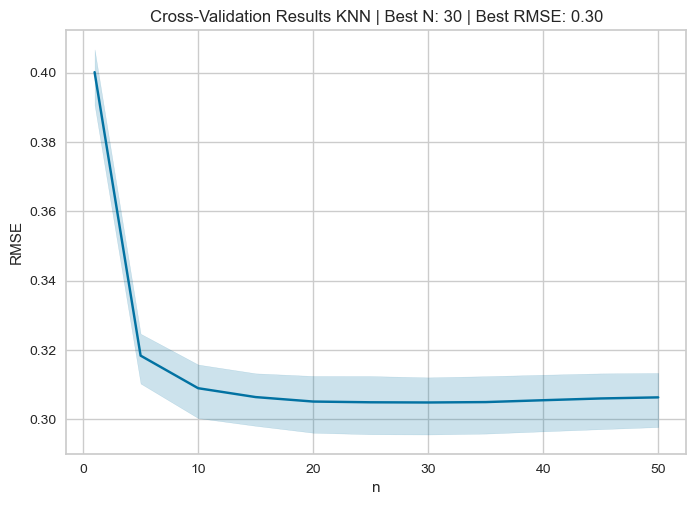

In [51]:
ax = sns.lineplot(x='n', y='RMSE', data=cv_rmse)

ax.set_title(f'Cross-Validation Results KNN | Best N: {best_n:d} | Best RMSE: {best_rmse:.2f}');
plt.show()

#### Actuals vs Predicted

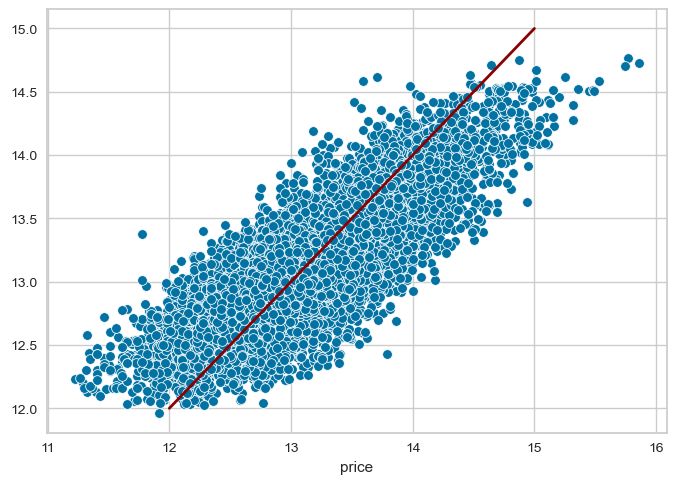

In [52]:
pipe = Pipeline([('scaler', StandardScaler()),
                 ('knn', KNeighborsRegressor(n_neighbors=best_n))])

y_pred = cross_val_predict(pipe, X, y, cv=5)

ax = sns.scatterplot(x=y, y=y_pred)
y_range = list(range(int(y.min() + 1), int(y.max() + 1)))
pd.Series(y_range, index=y_range).plot(ax=ax, lw=2, c='darkred');
plt.show()

#### Cross-Validation Errors

In [ ]:
error = (y - y_pred).rename('Prediction Errors')

In [ ]:
scores = dict(
    rmse=np.sqrt(mean_squared_error(y_true=y, y_pred=y_pred)),
    rmsle=np.sqrt(mean_squared_log_error(y_true=y, y_pred=y_pred)),
    mean_ae=mean_absolute_error(y_true=y, y_pred=y_pred),
    median_ae=median_absolute_error(y_true=y, y_pred=y_pred),
    r2score=explained_variance_score(y_true=y, y_pred=y_pred)
)

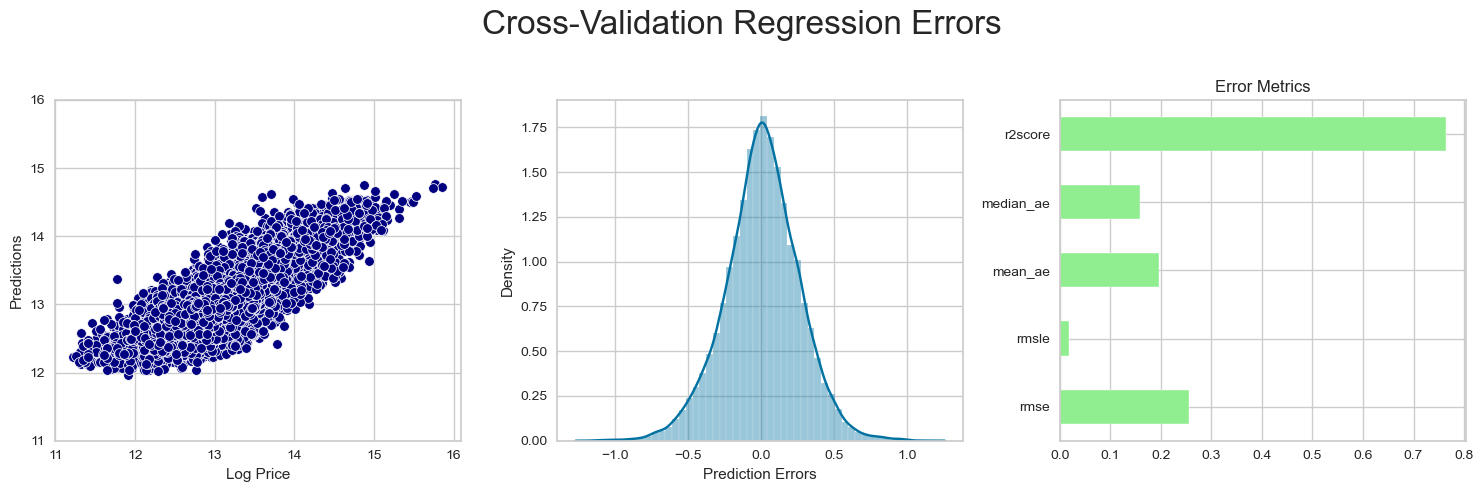

In [59]:
fig, axes = plt.subplots(ncols=3, figsize=(15, 5))
sns.scatterplot(x=y, y=y_pred, ax=axes[0], color='#000080')
axes[0].set_xlabel('Log Price')
axes[0].set_ylabel('Predictions')
axes[0].set_ylim(11, 16)
sns.distplot(error, ax=axes[1])
pd.Series(scores).plot.barh(ax=axes[2], title='Error Metrics', color='lightgreen')
fig.suptitle('Cross-Validation Regression Errors', fontsize=24)
fig.tight_layout()
plt.subplots_adjust(top=.8);
plt.show()

#### GridSearchCV with Pipeline

In [60]:
pipe = Pipeline([('scaler', StandardScaler()), 
                 ('knn', KNeighborsRegressor())])

n_folds = 5
n_neighbors = tuple(range(5, 101, 5))

param_grid = {'knn__n_neighbors': n_neighbors}

estimator = GridSearchCV(estimator=pipe,
                         param_grid=param_grid,
                         cv=n_folds,
                         scoring=rmse_score,
#                          n_jobs=-1
                        )
estimator.fit(X=X, y=y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsRegressor())]),
             param_grid={'knn__n_neighbors': (5, 10, 15, 20, 25, 30, 35, 40, 45,
                                              50, 55, 60, 65, 70, 75, 80, 85,
                                              90, 95, 100)},
             scoring=make_scorer(rmse, response_method='predict'))

In [61]:
cv_results = estimator.cv_results_

In [62]:
test_scores = pd.DataFrame({fold: cv_results[f'split{fold}_test_score'] for fold in range(n_folds)}, 
                           index=n_neighbors).stack().reset_index()

test_scores.columns = ['k', 'fold', 'RMSE']

In [63]:
mean_rmse = test_scores.groupby('k').RMSE.mean()

best_k, best_score = mean_rmse.idxmin(), mean_rmse.min()

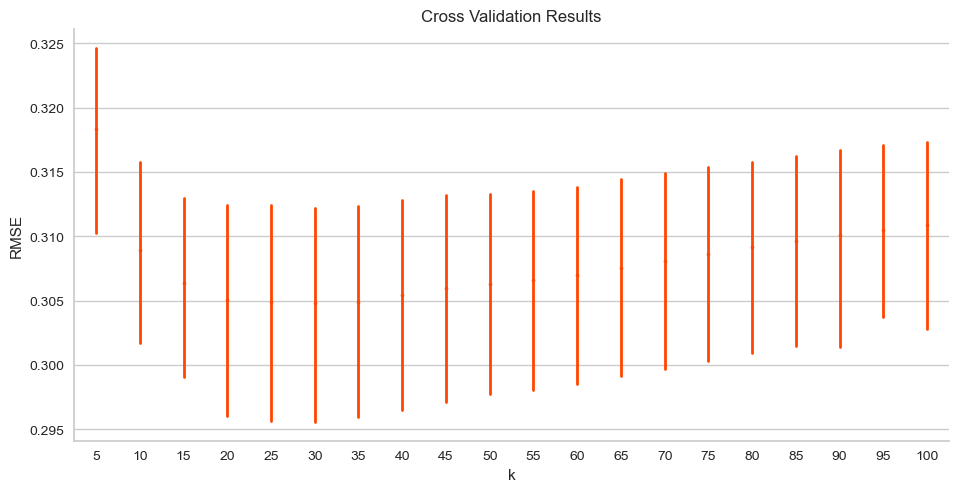

In [66]:
sns.pointplot(x='k', y='RMSE', data=test_scores, scale=.3, join=False, errwidth=2, color='orangered')
plt.title('Cross Validation Results')
sns.despine()
plt.tight_layout()
plt.gcf().set_size_inches(10, 5);
plt.show()

### Train & Validation Curves `mit YellowBricks`

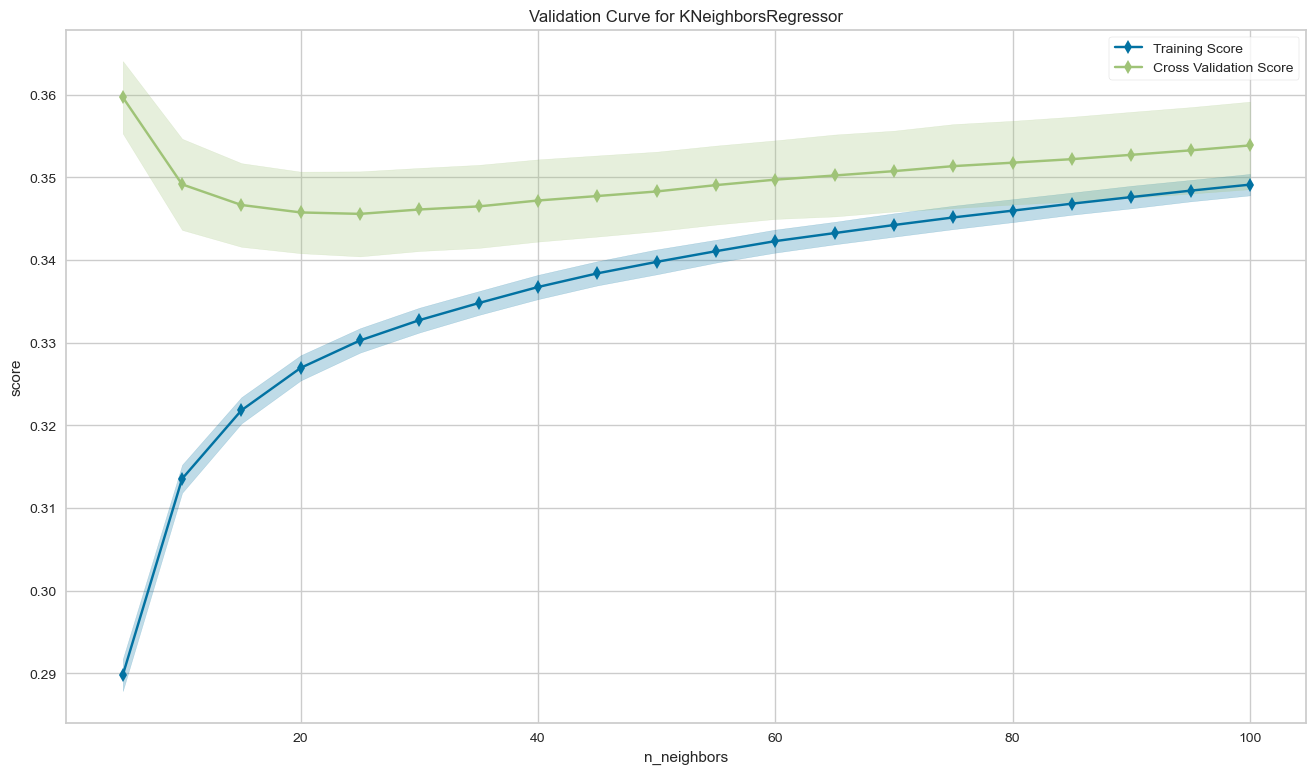

<Figure size 800x550 with 0 Axes>

In [67]:
fig, ax = plt.subplots(figsize=(16, 9))
val_curve = ValidationCurve(KNeighborsRegressor(),
                      param_name='n_neighbors',
                      param_range=n_neighbors,
                      cv=5,
                      scoring=rmse_score,
#                       n_jobs=-1,
                      ax=ax)
val_curve.fit(X, y)
val_curve.poof()
sns.despine()
fig.tight_layout();
plt.show()

<Figure size 800x550 with 0 Axes>

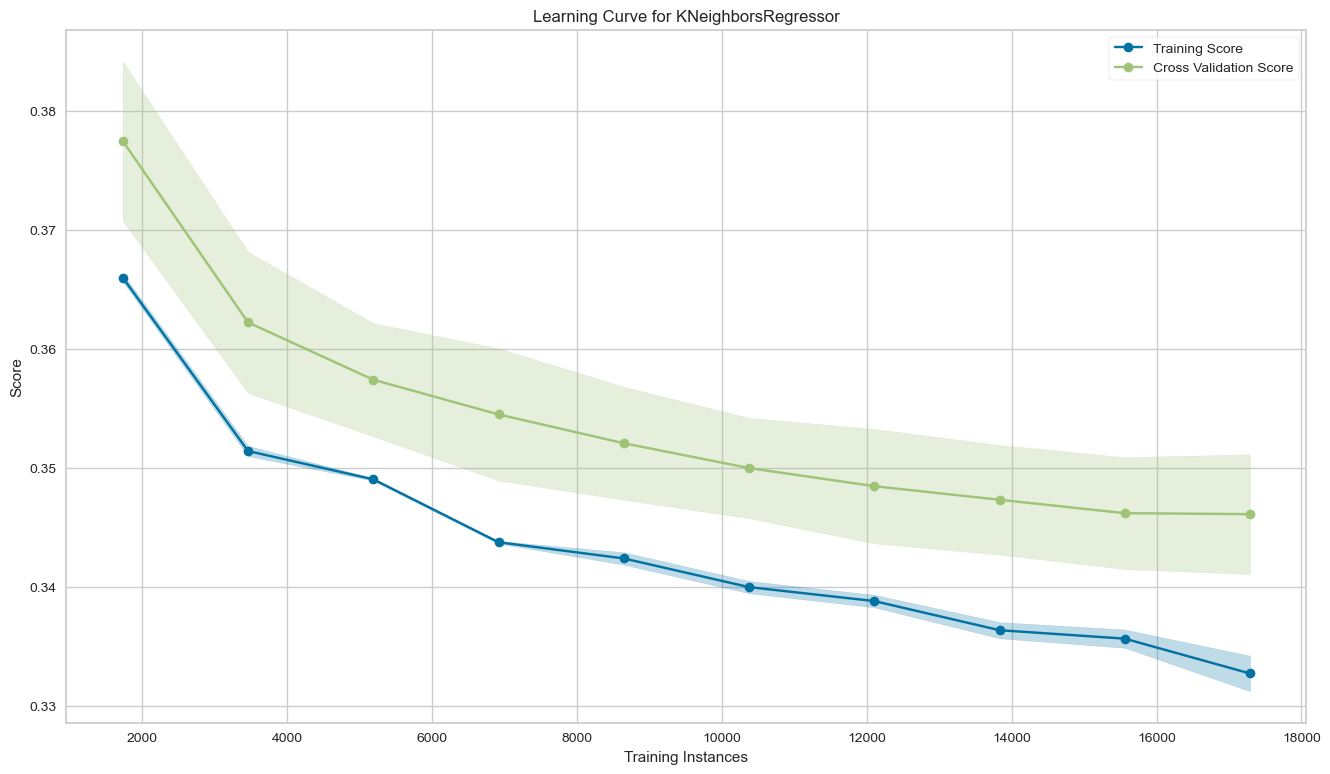

<Figure size 800x550 with 0 Axes>

In [69]:
fig, ax = plt.subplots(figsize=(16, 9))
l_curve = LearningCurve(KNeighborsRegressor(n_neighbors=best_k), 
                        train_sizes=np.arange(.1, 1.01, .1),
                        scoring=rmse_score, 
                        cv=5, 
#                         n_jobs=-1,
                        ax=ax)
l_curve.fit(X, y)
l_curve.poof()
sns.despine()
fig.tight_layout();
plt.show()

### Binary Classification

In [70]:
y_binary = (y>y.median()).astype(int)

In [71]:
n_neighbors = tuple(range(5, 151, 10))

n_folds = 5

scoring = 'roc_auc'

In [72]:
pipe = Pipeline([('scaler', StandardScaler()), 
                 ('knn', KNeighborsClassifier())])

param_grid = {'knn__n_neighbors': n_neighbors}

estimator = GridSearchCV(estimator=pipe,
                         param_grid=param_grid,
                         cv=n_folds,
                         scoring=scoring,
#                          n_jobs=-1
                        )
estimator.fit(X=X, y=y_binary)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': (5, 15, 25, 35, 45, 55, 65, 75, 85,
                                              95, 105, 115, 125, 135, 145)},
             scoring='roc_auc')

In [73]:
best_k = estimator.best_params_['knn__n_neighbors']

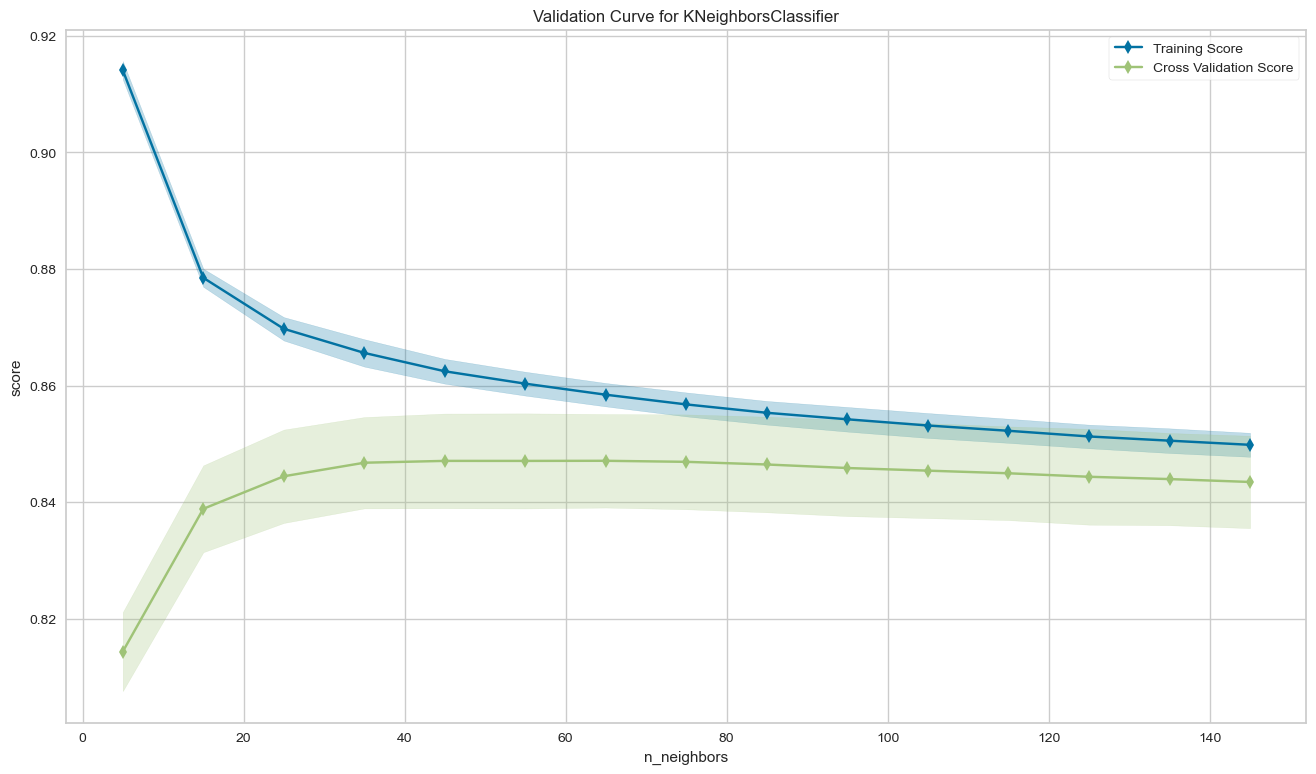

In [74]:
fig, ax = plt.subplots(figsize=(16, 9))
val_curve = ValidationCurve(KNeighborsClassifier(),
                      param_name='n_neighbors',
                      param_range=n_neighbors,
                      cv=n_folds,
                      scoring=scoring,
#                       n_jobs=-1,
                      ax=ax)
val_curve.fit(X, y_binary)
val_curve.poof()
sns.despine()
fig.tight_layout();

<Figure size 800x550 with 0 Axes>

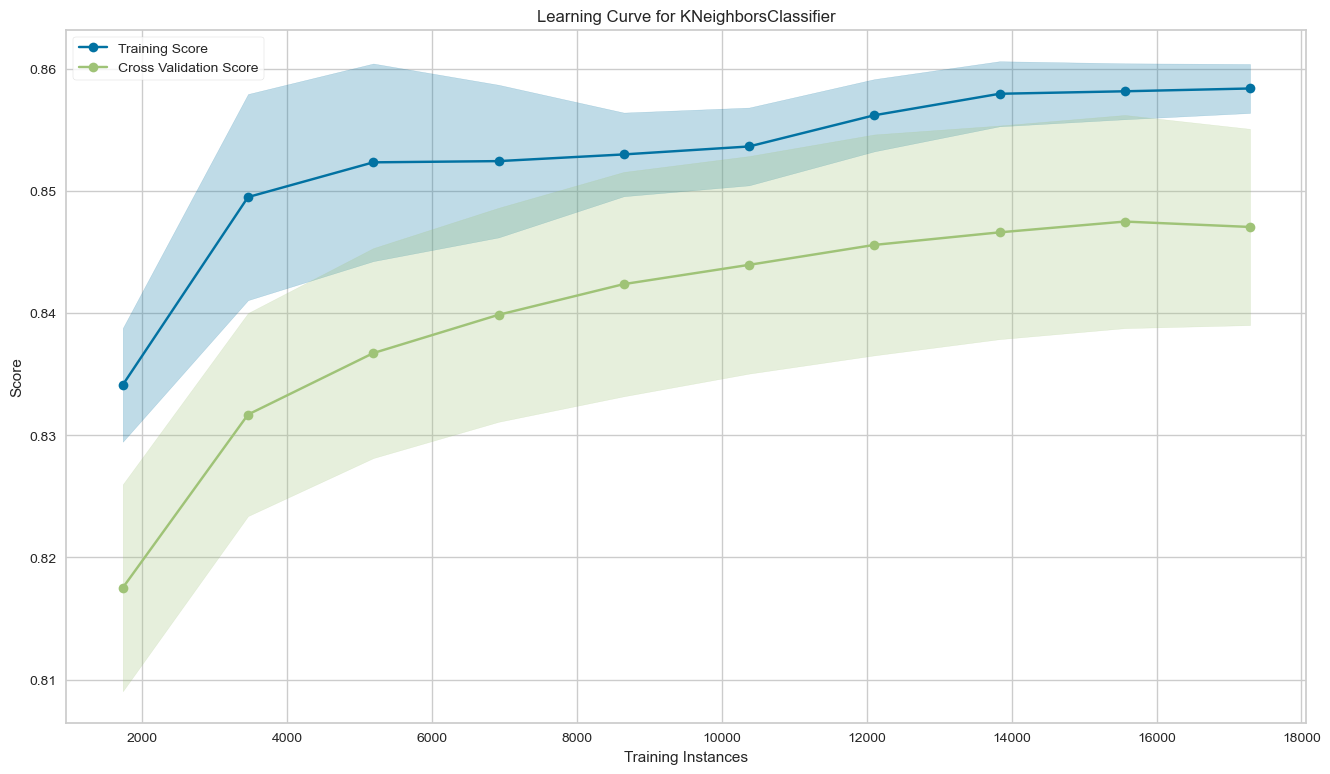

In [75]:
fig, ax = plt.subplots(figsize=(16, 9))
l_curve = LearningCurve(KNeighborsClassifier(n_neighbors=best_k), 
                        train_sizes=np.arange(.1, 1.01, .1),
                        scoring=scoring, 
                        cv=5, 
#                         n_jobs=-1,
                        ax=ax)
l_curve.fit(X, y_binary)
l_curve.poof()
sns.despine()
fig.tight_layout();

### Classification Metrics

In [76]:
from sklearn.metrics import (classification_report,
                             accuracy_score,
                             zero_one_loss,
                             roc_auc_score,
                             roc_curve,
                             brier_score_loss,
                             cohen_kappa_score,
                             confusion_matrix,
                             fbeta_score,
                             hamming_loss,
                             hinge_loss,
                             jaccard_score,
                             log_loss,
                             matthews_corrcoef,
                             f1_score,
                             average_precision_score,
                             precision_recall_curve)

In [77]:
y_score = cross_val_predict(KNeighborsClassifier(best_k), 
                           X=X, 
                           y=y_binary, 
                           cv=5, 
                           n_jobs=-1, 
                           method='predict_proba')[:, 1]

#### Using Predicted Probabilities

In [78]:
pred_scores = dict(y_true=y_binary,y_score=y_score)

#### ROC AUC

In [79]:
roc_auc_score(**pred_scores)

np.float64(0.8460169463310011)

In [80]:
cols = ['False Positive Rate', 'True Positive Rate', 'threshold']

roc = pd.DataFrame(dict(zip(cols, roc_curve(**pred_scores))))

#### Precision-Recall

In [81]:
precision, recall, ts = precision_recall_curve(y_true=y_binary, probas_pred=y_score)

pr_curve = pd.DataFrame({'Precision': precision, 'Recall': recall})

#### F1 Score - Optimize Threshold

In [82]:
f1 = pd.Series({t: f1_score(y_true=y_binary, y_pred=y_score>t) for t in ts})

best_threshold = f1.idxmax()

#### Plotting

In [83]:
roc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67 entries, 0 to 66
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   False Positive Rate  67 non-null     float64
 1   True Positive Rate   67 non-null     float64
 2   threshold            67 non-null     float64
dtypes: float64(3)
memory usage: 1.7 KB


<Figure size 800x550 with 0 Axes>

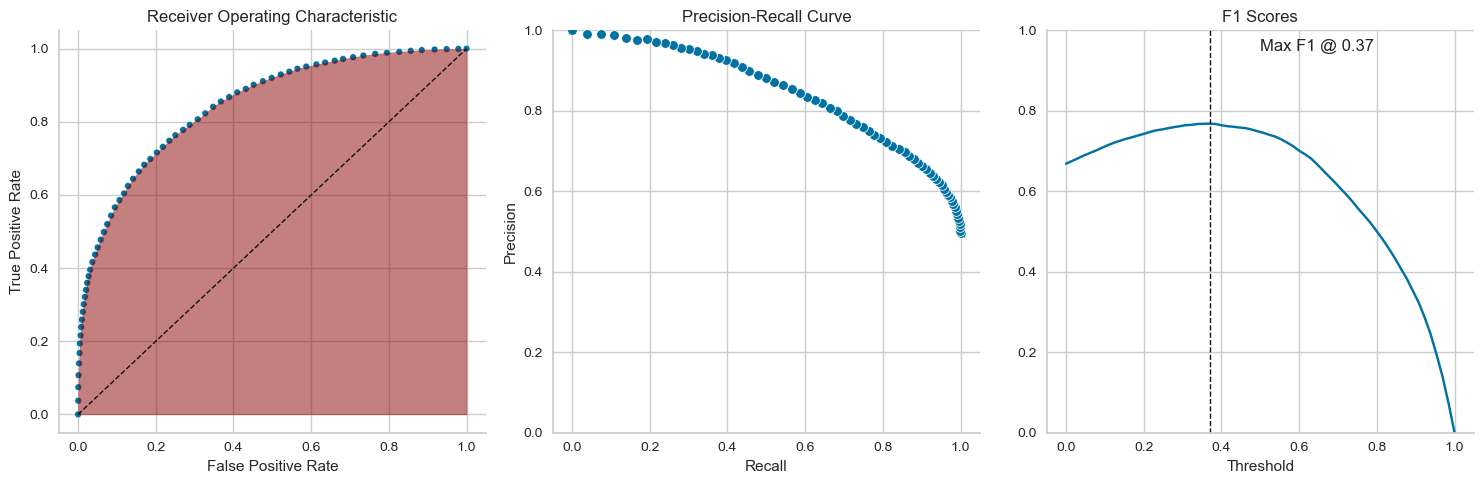

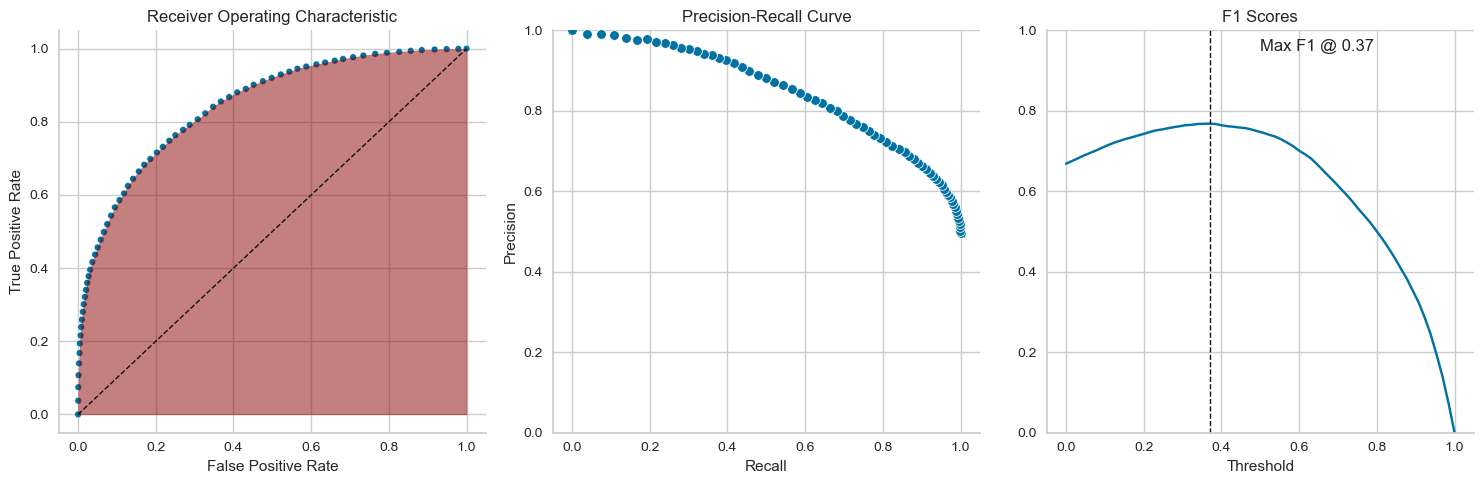

In [85]:
fig, axes = plt.subplots(ncols=3, figsize=(15, 5))

ax = sns.scatterplot(x='False Positive Rate', y='True Positive Rate', data=roc, size=5, legend=False, ax=axes[0])
axes[0].plot(np.linspace(0,1,100), np.linspace(0,1,100), color='k', ls='--', lw=1)
axes[0].fill_between(y1=roc['True Positive Rate'], x=roc['False Positive Rate'], alpha=.5,color='darkred')
axes[0].set_title('Receiver Operating Characteristic')


sns.scatterplot(x='Recall', y='Precision', data=pr_curve, ax=axes[1])
axes[1].set_ylim(0,1)
axes[1].set_title('Precision-Recall Curve')


f1.plot(ax=axes[2], title='F1 Scores', ylim=(0,1))
axes[2].set_xlabel('Threshold')
axes[2].axvline(best_threshold, lw=1, ls='--', color='k')
axes[2].text(s=f'Max F1 @ {best_threshold:.2f}', x=.5, y=.95)
sns.despine()
fig.tight_layout();
plt.show()

#### Average Precision

In [86]:
average_precision_score(y_true=y_binary, y_score=y_score)

np.float64(0.8484132538564065)

#### Brier Score

In [87]:
brier_score_loss(y_true=y_binary, y_prob=y_score)

np.float64(0.16023119988326112)

#### Using Predictions after Thresholding

In [88]:
y_pred = y_score > best_threshold

In [89]:
scores = dict(y_true=y_binary, y_pred=y_pred)

#### F-beta Score

In [90]:
fbeta_score(**scores, beta=1)

0.7684210526315789

In [91]:
print(classification_report(**scores))

              precision    recall  f1-score   support

           0       0.82      0.63      0.71     10864
           1       0.70      0.86      0.77     10749

    accuracy                           0.74     21613
   macro avg       0.76      0.74      0.74     21613
weighted avg       0.76      0.74      0.74     21613



#### Confusion Matrix

In [92]:
confusion_matrix(**scores)

array([[6871, 3993],
       [1551, 9198]])

#### Accuracy

In [93]:
accuracy_score(**scores)

0.743487715726646

#### Zero-One Loss

In [94]:
zero_one_loss(**scores)

0.25651228427335404

#### Hamming Loss

In [95]:
hamming_loss(**scores)

0.256512284273354

#### Cohen's Kappa

In [96]:
cohen_kappa_score(y1=y_binary, y2=y_pred)

np.float64(0.4875770533373557)

#### Hinge Loss

In [97]:
hinge_loss(y_true=y_binary, pred_decision=y_pred)

np.float64(0.7591727201221488)

#### Jaccard Similarity

In [98]:
jaccard_score(**scores)

np.float64(0.6239316239316239)

#### Log Loss / Cross Entropy Loss

In [99]:
log_loss(**scores)

9.24563986439946

#### Matthews Correlation Coefficient

In [100]:
matthews_corrcoef(**scores)

np.float64(0.5004925066659417)

### Multi-Class

In [101]:
y_multi = pd.qcut(y, q=3, labels=[0,1,2])

In [102]:
n_neighbors = tuple(range(5, 151, 10))

n_folds = 5

scoring = 'accuracy'

In [103]:
pipe = Pipeline([('scaler', StandardScaler()), 
                 ('knn', KNeighborsClassifier())])

param_grid = {'knn__n_neighbors': n_neighbors}

estimator = GridSearchCV(estimator=pipe,
                         param_grid=param_grid,
                         cv=n_folds,
                         n_jobs=-1
                        )

estimator.fit(X=X, y=y_multi)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'knn__n_neighbors': (5, 15, 25, 35, 45, 55, 65, 75, 85,
                                              95, 105, 115, 125, 135, 145)})

In [104]:
y_pred = cross_val_predict(estimator.best_estimator_, 
                           X=X, 
                           y=y_multi, 
                           cv=5, 
                           n_jobs=-1, 
                           method='predict')

In [105]:
print(classification_report(y_true=y_multi, y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.67      0.71      0.69      7226
           1       0.52      0.52      0.52      7223
           2       0.77      0.74      0.75      7164

    accuracy                           0.65     21613
   macro avg       0.65      0.65      0.65     21613
weighted avg       0.65      0.65      0.65     21613

